<a href="https://colab.research.google.com/github/kupaqu/deeptable-gan/blob/main/10feb_DeepTable_GAN_softMax_csv_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import math
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import init
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.io import arff

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Датасет

In [ ]:
!unzip -qq /content/drive/MyDrive/31jan_data/csv.zip -d /content/data

In [ ]:
def fit_evaluate(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

@ignore_warnings(category=ConvergenceWarning)
def get_lambda(X, y, clfs=None):
    if clfs is None:
        clfs = [LogisticRegression(max_iter=1000), GaussianNB(), RandomForestClassifier()]
    scores = np.array([fit_evaluate(clf, X, y) for clf in clfs])
    lambda_ = np.exp(scores)/sum(np.exp(scores)) # softmax

    return lambda_

def get_binary_clf_datasets(path='/content/data/'):
    Xs, ys, lambdas = [], [], []

    for dir in os.listdir(path):
        dirpath = os.path.join(path, dir)

        zero = pd.read_csv(os.path.join(dirpath, 'zero.csv'), header=None)
        one = pd.read_csv(os.path.join(dirpath, 'one.csv'), header=None)

        X = torch.tensor(pd.concat([zero, one], axis=0).values, dtype=torch.float32)
        y = torch.cat((torch.zeros((len(zero),)), torch.ones((len(one),))), dim=0)
        lambda_ = torch.tensor(get_lambda(X, y), dtype=torch.float32)

        Xs.append(X)
        ys.append(y)
        lambdas.append(lambda_)

    return Xs, ys, lambdas

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def get_batch_lambda(X, y, clfs=None):
    X, y = X.detach().numpy(), y.detach().numpy()
    X = X.reshape(-1, 16, 128)
    X = np.transpose(X, (0, 2, 1))
    y = y.reshape(-1, 128)

    lambdas = np.zeros((X.shape[0], 3))
    for i in range(X.shape[0]):
        if clfs is None:
            clfs = [LogisticRegression(max_iter=1000), GaussianNB(), RandomForestClassifier()]
        scores = np.array([fit_evaluate(clone(clf), X[i], y[i]) for clf in clfs])
        lambda_ = np.exp(scores)/sum(np.exp(scores))

        lambdas[i] = lambda_

    return torch.tensor(lambdas, dtype=torch.float32)

class OpenMLDataset(torch.utils.data.Dataset):
    def __init__(self, Xs, ys, lambdas):
        self.Xs = Xs,
        self.ys = ys,
        self.lambdas = lambdas

    def __len__(self):
        return len(self.Xs[0])

    def __getitem__(self, idx):
        X = torch.permute(self.Xs[0][idx], (1, 0)) # первое измерение должно быть столбцами
        y = self.ys[0][idx]
        lambda_ = self.lambdas[idx]

        return X, y, lambda_

# DeepSets

In [ ]:
r"""
Permutation Equivariant and Permutation Invariant layers, as described in the
paper Deep Sets, by Zaheer et al. (https://arxiv.org/abs/1703.06114)
"""
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max', 'min'],  \
            '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)
        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M, dtype=torch.bool).to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta)/sizes

        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)


class EquivLinear(InvLinear):
    r"""Permutation equivariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(EquivLinear, self).__init__(in_features, out_features,
                                          bias=bias, reduction=reduction)

        self.alpha = nn.Parameter(torch.Tensor(self.in_features,
                                               self.out_features))

        self.reset_parameters()

    def reset_parameters(self):
        super(EquivLinear, self).reset_parameters()
        if hasattr(self, 'alpha'):
            init.xavier_uniform_(self.alpha)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to the output set
        Y = {y_1, ..., y_M} through a permutation equivariant linear transformation
        of the form:
            $y_i = \alpha x_i + \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N sets of same cardinality as in X where each element has dimension
           out_features (tensor with shape (N, M, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        Y = torch.zeros(N, M, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M, dtype=torch.bool).to(device)

        Y = torch.zeros(N, M, self.out_features).to(device)
        h_inv = super(EquivLinear, self).forward(X, mask=mask)
        Y[mask] = (X @ self.alpha + h_inv.unsqueeze(1))[mask]

        return Y

# Модель

In [ ]:
class DeepTable(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.equiv_0 = EquivLinear(1, 64)
        self.inv_0 = InvLinear(64, 128)
        self.equiv_1 = EquivLinear(128, 256)
        self.inv_1 = InvLinear(256, 512)

    def forward(self, x):
        N = x.shape[1] # количество столбцов в таблице
        x = x.unsqueeze(-1) # (batch_size, N, M, 1)
        x = x.flatten(0, 1) # (batch_size * N, M, 1)

        x = self.equiv_0(x) # (batch_size * N, M, 64)
        x = F.relu(x)
        x = self.inv_0(x) # (batch_size * N, 128)
        x = x.reshape(-1, N, 128) # (batch_size, N, 128)

        x = self.equiv_1(x) # (batch_size, N, 256)
        x = F.relu(x)
        x = self.inv_1(x) # (batch_size, 512)

        return x

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, n_clfs=3):
        super().__init__()
        self.deeptable = DeepTable()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, n_clfs),
        )
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        features = self.deeptable(x)
        lambda_ = self.classifier(features)
        label = self.discriminator(features) # метка датасета (реальный он или сгенерирован генеративной моделью)

        return lambda_, label

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 64, kernel_size=(4, 7)), # не добавляем паддинг и страйд т. к. делит на классы
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 128, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 32, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(32, 1, kernel_size=(4, 8), stride=(1, 2), padding=(0, 2))
        )

    def forward(self, x):
        return self.upconv(x)

# Train loooop

In [ ]:
def train_d(d, g, opt, real_tables, real_target_lambdas, device='cpu'):
    opt.zero_grad()
    batch_size = real_tables.size(0)
    real_tables = real_tables.to(device)

    # реальные таблицы
    real_pred_lambdas, real_pred_labels = d(real_tables)
    real_target_labels = torch.ones(batch_size, 1, device=device)

    real_clf_loss = nn.functional.cross_entropy(real_pred_lambdas, real_target_lambdas)
    real_d_loss = nn.functional.binary_cross_entropy(real_pred_labels, real_target_labels)
    real_loss = real_clf_loss + real_d_loss

    # фейковые таблицы
    z = torch.randn(batch_size, 32, 1, 1, device=device)
    # fake_tables = g(z).view_as(real_tables)
    fake_tables = g(z).view(-1, 16, 128)
    fake_y = torch.cat((torch.zeros((batch_size, 64)), torch.ones((batch_size, 64))), dim=1).to(device)
    fake_target_lambdas = get_batch_lambda(fake_tables.to('cpu'), fake_y.to('cpu')).to(device)

    fake_pred_lambdas, fake_pred_labels = d(fake_tables)
    fake_target_labels = torch.zeros(batch_size, 1, device=device)

    fake_clf_loss = nn.functional.cross_entropy(fake_pred_lambdas, fake_target_lambdas)
    fake_d_loss = nn.functional.binary_cross_entropy(fake_pred_labels, fake_target_labels)

    alpha = 0.5
    fake_loss = alpha*fake_clf_loss + fake_d_loss

    # обновление весов
    loss = real_loss + fake_loss
    loss.backward()
    opt.step()

    return loss.item()

def train_g(d, g, opt, real_tables, device='cpu'):
    opt.zero_grad()
    batch_size = real_tables.size(0)

    # генерация
    latent = torch.randn(batch_size, 32, 1, 1, device=device)
    # fake_tables = g(latent).view_as(real_tables)
    fake_tables = g(latent).view(-1, 16, 128)

    # предсказания дискриминатора
    lambdas, labels = d(fake_tables)
    targets = torch.ones(batch_size, 1, device=device)

    loss = nn.functional.binary_cross_entropy(labels, targets)

    loss.backward()
    opt.step()

    return loss.item()

def batch_accuracy_and_f1_macro(pred, target):
    batch_size = pred.size(0)

    pred_ids = pred.cpu().argmax(dim=1, keepdim=False)
    target_ids = target.cpu().argmax(dim=1, keepdim=False)

    acc = multiclass_accuracy(pred_ids, target_ids)
    f1_macro = multiclass_f1_score(pred_ids, target_ids, num_classes=3, average='macro')

    return acc, f1_macro

def eval_d(d, g, tables, target_lambdas, device='cpu'):
    tables = tables.to(device)
    pred_lambdas, pred_labels = d(tables)
    clf_accuracy, clf_f1_macro = batch_accuracy_and_f1_macro(pred_lambdas, target_lambdas)
    clf_mae = torch.nn.functional.l1_loss(pred_lambdas.cpu(), target_lambdas.cpu())

    return clf_accuracy, clf_f1_macro, clf_mae

def train_gan(d, g, d_opt, g_opt, real_tables, real_target_lambdas, device='cpu'):
    d_loss = train_d(d, g, d_opt, real_tables, real_target_lambdas, device)
    g_loss = train_g(d, g, g_opt, real_tables, device)

    return d_loss, g_loss

def train_epoch(d, g, d_opt, g_opt, train_dataloader, val_dataloader, device='cpu'):
    running_d_loss, running_g_loss = 0., 0.
    real_running_lambda_accuracy, real_running_lambda_f1_macro, real_running_lambda_mae = 0., 0., 0.
    fake_running_lambda_accuracy, fake_running_lambda_f1_macro, fake_running_lambda_mae = 0., 0., 0.
    val_running_lambda_accuracy, val_running_lambda_f1_macro, val_running_lambda_mae = 0., 0., 0.

    for X, y, lambda_ in tqdm(train_dataloader):
        X = X.to(device)
        lambda_ = lambda_.to(device)
        d_loss, g_loss = train_gan(d, g, d_opt, g_opt, X, lambda_, device=device)
        running_d_loss += d_loss
        running_g_loss += g_loss

        with torch.no_grad():
            z = torch.randn(X.size(0), 32, 1, 1, device=device)
            # fake_tables = g(z).view_as(X)
            fake_tables = g(z).view(-1, 16, 128)
            fake_y = torch.cat((torch.zeros((X.size(0), 64)), torch.ones((X.size(0), 64))), dim=1).to(device)
            fake_target_lambdas = get_batch_lambda(fake_tables.to('cpu'), fake_y.to('cpu')).to(device)

            real_lambda_accuracy, real_lambda_f1_macro, real_lambda_mae = eval_d(d, g, X, lambda_, device)
            fake_lambda_accuracy, fake_lambda_f1_macro, fake_lambda_mae = eval_d(d, g, fake_tables, fake_target_lambdas, device)

            real_running_lambda_accuracy += real_lambda_accuracy
            real_running_lambda_f1_macro += real_lambda_f1_macro
            real_running_lambda_mae += real_lambda_mae
            fake_running_lambda_accuracy += fake_lambda_accuracy
            fake_running_lambda_f1_macro += fake_lambda_f1_macro
            fake_running_lambda_mae += fake_lambda_mae

    with torch.no_grad():
        for X, y, lambda_ in val_dataloader:
            val_lambda_accuracy, val_lambda_f1_macro, val_lambda_mae = eval_d(d, g, X, lambda_, device)
            val_running_lambda_accuracy += val_lambda_accuracy
            val_running_lambda_f1_macro += val_lambda_f1_macro
            val_running_lambda_mae += val_lambda_mae

    n_train = len(train_dataloader)
    n_val = len(val_dataloader)

    return {
        'd_loss': running_d_loss / n_train,
        'g_loss': running_g_loss / n_train,

        'real_lambda_accuracy': real_running_lambda_accuracy.item() / n_train,
        'real_lambda_f1_macro': real_running_lambda_f1_macro.item() / n_train,
        'real_lambda_mae': real_running_lambda_mae.item() / n_train,

        'fake_lambda_accuracy': fake_running_lambda_accuracy.item() / n_train,
        'fake_lambda_f1_macro': fake_running_lambda_f1_macro.item() / n_train,
        'fake_lambda_mae': fake_running_lambda_mae.item() / n_train,

        'val_lambda_accuracy': val_running_lambda_accuracy.item() / n_val,
        'val_lambda_f1_macro': val_running_lambda_f1_macro.item() / n_val,
        'val_lambda_mae': val_running_lambda_mae.item() / n_val
    }

# Обучение

In [ ]:
def get_dataloader(val_size=0.2, batch_size=64):
    Xs, ys, lambdas = get_binary_clf_datasets()
    Xs_train, Xs_val, ys_train, ys_val, lambdas_train, lambdas_val = train_test_split(Xs, ys, lambdas, test_size=val_size)

    train_dataset = OpenMLDataset(Xs_train, ys_train, lambdas_train)
    val_dataset = OpenMLDataset(Xs_val, ys_val, lambdas_val)

    print(f'Train size: {len(train_dataset)}, test size: {len(val_dataset)})')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader

In [ ]:
train_dataloader, val_dataloader = get_dataloader(batch_size=64)

Train size: 7928, test size: 1983)


In [ ]:
device = 'cuda'

d = Discriminator().to(device)
d_opt = torch.optim.Adam(d.parameters(), lr=0.0003)

g = Generator().to(device)
g_opt = torch.optim.Adam(g.parameters(), lr=0.0003)

In [ ]:
def plot_history(history):
    d_losses = [history[i]['d_loss'] for i in range(len(history))]
    g_losses = [history[i]['g_loss'] for i in range(len(history))]
    plt.plot(d_losses)
    plt.plot(g_losses)
    plt.title('GAN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['d_loss', 'g_loss'], loc='upper left')
    plt.show()

    real_lambda_accuracies = [history[i]['real_lambda_accuracy'] for i in range(len(history))]
    fake_lambda_accuracies = [history[i]['fake_lambda_accuracy'] for i in range(len(history))]
    val_lambda_accuracies = [history[i]['val_lambda_accuracy'] for i in range(len(history))]
    plt.plot(real_lambda_accuracies)
    plt.plot(fake_lambda_accuracies)
    plt.plot(val_lambda_accuracies)
    plt.title('Lambda classifier accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_accuracy', 'fake_lambda_accuracy', 'val_lambda_accuracy'], loc='upper left')
    plt.show()

    real_lambda_f1_macros = [history[i]['real_lambda_f1_macro'] for i in range(len(history))]
    fake_lambda_f1_macros = [history[i]['fake_lambda_f1_macro'] for i in range(len(history))]
    val_lambda_f1_macros = [history[i]['val_lambda_f1_macro'] for i in range(len(history))]
    plt.plot(real_lambda_f1_macros)
    plt.plot(fake_lambda_f1_macros)
    plt.plot(val_lambda_f1_macros)
    plt.title('Lambda classifier F1')
    plt.ylabel('F1 macro')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_f1_macro', 'fake_lambda_f1_macro', 'val_lambda_f1_macro'], loc='upper left')
    plt.show()

    real_lambda_mae = [history[i]['real_lambda_mae'] for i in range(len(history))]
    fake_lambda_mae = [history[i]['fake_lambda_mae'] for i in range(len(history))]
    val_lambda_mae = [history[i]['val_lambda_mae'] for i in range(len(history))]
    plt.plot(real_lambda_mae)
    plt.plot(fake_lambda_mae)
    plt.plot(val_lambda_mae)
    plt.title('Lambda classifier MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_mae', 'fake_lambda_mae', 'val_lambda_mae'], loc='upper left')
    plt.show()

In [ ]:
history = []
for epoch in range(10):
    print(f'Epoch {epoch+1}:')
    history.append(train_epoch(d, g, d_opt, g_opt, train_dataloader, val_dataloader, device=device))
    print(history[epoch])
    print()

Epoch 1:


100%|██████████| 124/124 [45:22<00:00, 21.96s/it]


{'d_loss': 2.554246715960964, 'g_loss': 0.7072582071827304, 'real_lambda_accuracy': 0.341193845195155, 'real_lambda_f1_macro': 0.29696818320981916, 'real_lambda_mae': 0.07986933185208228, 'fake_lambda_accuracy': 0.3521565468080582, 'fake_lambda_f1_macro': 0.29092690252488657, 'fake_lambda_mae': 0.06821180159045805, 'val_lambda_accuracy': 0.32981309583110197, 'val_lambda_f1_macro': 0.3048657755697927, 'val_lambda_mae': 0.05497284089365313}

Epoch 2:


100%|██████████| 124/124 [44:57<00:00, 21.75s/it]


{'d_loss': 2.524528140021909, 'g_loss': 0.6815692618969948, 'real_lambda_accuracy': 0.31988048553466797, 'real_lambda_f1_macro': 0.3019292892948274, 'real_lambda_mae': 0.03992655969435169, 'fake_lambda_accuracy': 0.3650453629032258, 'fake_lambda_f1_macro': 0.32025838667346584, 'fake_lambda_mae': 0.040246148263254476, 'val_lambda_accuracy': 0.27332149013396234, 'val_lambda_f1_macro': 0.26983491836055634, 'val_lambda_mae': 0.03669013515595467}



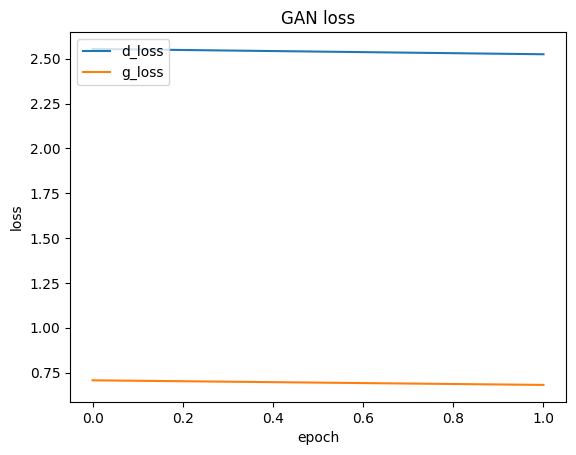

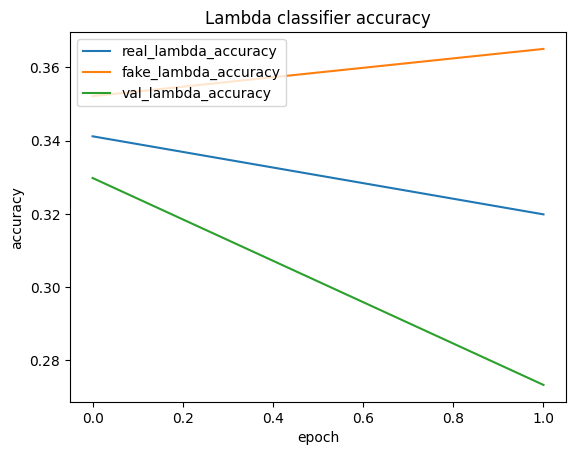

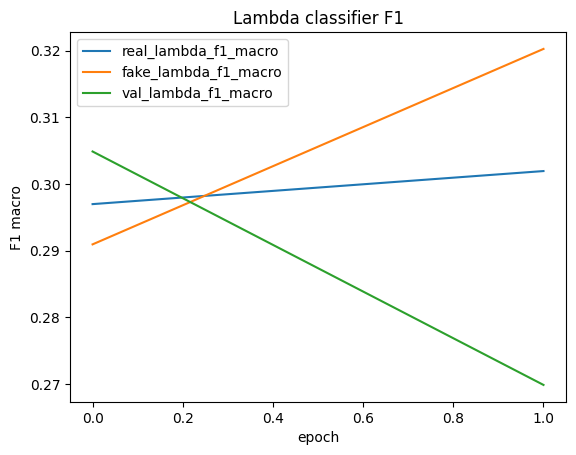

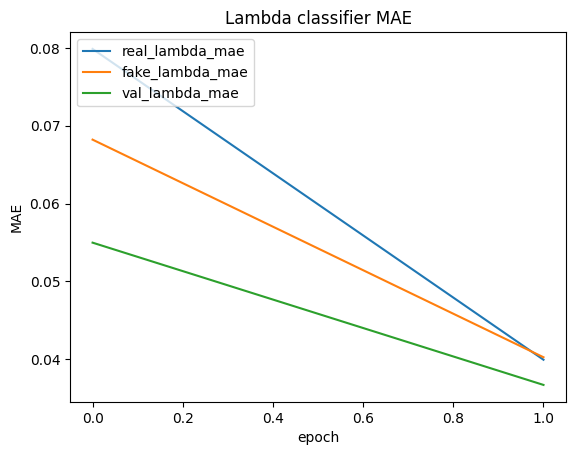

In [ ]:
plot_history(history)